<img src="https://heig-vd.ch/docs/default-source/doc-global-newsletter/2020-slim.svg" alt="Logo HEIG-VD" style="width: 80px;" align="right"/>

# Cours APN - Labo 2 : Comparaison de méthodes <br>de groupement sur des données biomédicales

## Résumé

L'objectif de ce laboratoire est de comparer deux méthodes de groupement : _k_-moyennes et DBSCAN.  

Le jeu de données vient du domaine biomédical et possède une annotation de référence.  

Les tâches demandées sont les suivantes :
* préparer les données à partir de données brutes disponibles en ligne
* pour chaque méthode de groupement
  - décider quels sont les meilleurs hyper-paramètres par évaluation intrinsèque
  - avec ces paramètres, afficher aussi les scores par évaluation extrinsèque
  - visualiser les groupements en 2D
* comparer les deux méthodes de groupement et conclure.

In [34]:
# Nom et prénom : CHARBONNIER LUCAS et ANCAY Rémi

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
os.environ["OMP_NUM_THREADS"] = "1" # KMeans is known to have a memory leak ... set OMP_NUM_THREADS=1

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

from sklearn.metrics import davies_bouldin_score as dbs
from sklearn.metrics import silhouette_score as sis
from sklearn.metrics import adjusted_rand_score as ars
from sklearn.metrics import f1_score

from matplotlib.colors import Normalize # peut aider au coloriage des groupes (ou utiliser Seaborn)

## 1. Prise en main et analyse exploratoire des données

Les données biomédicales ont été présentées dans l'article de Todd R. Golub et al., [Molecular classification of cancer: class discovery and class prediction by gene expression monitoring](https://www.science.org/doi/abs/10.1126/science.286.5439.531), *Science*, 286:531-537, 1999.  Ces données représentent l'expression de **7129 gènes** dans des échantillons sanguins et de moëlle osseuse provenant de 72 patients souffrant de leucémie.  Pour chaque gène, son niveau d'expression est codé comme un nombre entier, positif ou négatif.  Le type de leucémie a été annoté pour chaque patient comme ALL ou AML (*acute lymphoblastic leukemia* ou *acute myeloid leukemia*) : ce sont les deux classes de référence.

Les données sont à télécharger depuis [une version fournie par C. Crawford sur Kaggle](https://www.kaggle.com/datasets/crawford/gene-expression) (pour information, une autre version se trouve dans le [package R golubEsets](https://master.bioconductor.org/packages/release/data/experiment/html/golubEsets.html)).  Si vous n'avez pas accès à Kaggle, le fichier `archive.zip` est fourni avec ce notebook.  Les données brutes contiennent :
* un fichier `train` avec les données de 38 patients : noms des gènes (longs et courts), niveau d'expression, signifiance ('call')
* un fichier `independent` avec les données de 34 autres patients
* un fichier `actual` qui indique pour chaque patient son type de leucémie (ALL ou AML)

**Le premier but est d'obtenir une DataFrame avec les 72 patients (lignes) et les niveaux des 7129 gènes (colonnes).  Le numéro de patient sert d'index.  Enfin, une colonne indiquera le type de chaque patient.**

a. Veuillez compléter le code ci-dessous pour transformer le premier fichier de données en un tableau:
* avec 7129 colonnes correspondant à la valeur exprimée de chaque gène pour chaque patient
* les noms des 7129 colonnes sont les noms courts de chaque gène (connus comme *Gene Accession Number*) 
* indexé par le numéro des patients, qui sera appelé 'Patient'

In [36]:
def conversion_donnees_brutes(f):
    # Lire le fichier f
    df = pd.read_csv(f)

    cols = [c for c in df.columns if not c.startswith('call')]
    df = df[cols]

    df = df.T

    # les nom des colonnes sont le Gene Accession Number
    df.columns = df.iloc[1]
    df.columns.name = 'Patient'

    # les lignes sont les patients
    df = df.drop(['Gene Accession Number', 'Gene Description'])

    df.index = df.index.astype(int)
    df = df.astype(int)

    return df


In [37]:
train_df = conversion_donnees_brutes(os.path.join('data', 'data_set_ALL_AML_train.csv'))
print(train_df.shape) # vérifie le résultat : (38, 7129)
train_df.head(3)

(38, 7129)


Patient,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
1,-214,-153,-58,88,-295,-558,199,-176,252,206,...,185,511,-125,389,-37,793,329,36,191,-37
2,-139,-73,-1,283,-264,-400,-330,-168,101,74,...,169,837,-36,442,-17,782,295,11,76,-14
3,-76,-49,-307,309,-376,-650,33,-367,206,-215,...,315,1199,33,168,52,1138,777,41,228,-41


b. Veuillez appliquer la même fonction au deuxième fichier de données.

In [38]:
test_df = conversion_donnees_brutes(os.path.join('data', 'data_set_ALL_AML_independent.csv'))
print(test_df.shape) # vérifier le résultat : (34, 7129)
test_df.head(3)

(34, 7129)


Patient,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
39,-342,-200,41,328,-224,-427,-656,-292,137,-144,...,277,1023,67,214,-135,1074,475,48,168,-70
40,-87,-248,262,295,-226,-493,367,-452,194,162,...,83,529,-295,352,-67,67,263,-33,-33,-21
42,22,-153,17,276,-211,-250,55,-141,0,500,...,413,399,16,558,24,893,297,6,1971,-42


c. Veuillez fusionner les deux data frames en mettant les patients dans l'ordre 1 à 72.

In [39]:
total_df = pd.concat([train_df, test_df])
total_df.sort_index(inplace=True)

d.  En utilisant le fichier `actual.csv`, veuillez ajouter à **total_df** une colonne intitulée **type**, qui indique pour chaque patient son type de maladie (ALL ou AML).  Attention, cette colonne servira uniquement pour l'évaluation extrinsèque en fin de labo.

In [40]:
# Ajout de la nouvelle colonne
patients = pd.read_csv(os.path.join('data', 'actual.csv'))
patients.sort_index(inplace=True)
total_df["type"] = patients["cancer"]

print(total_df.shape)
total_df.head()

(72, 7130)


Patient,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,...,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at,type
1,-214,-153,-58,88,-295,-558,199,-176,252,206,...,511,-125,389,-37,793,329,36,191,-37,ALL
2,-139,-73,-1,283,-264,-400,-330,-168,101,74,...,837,-36,442,-17,782,295,11,76,-14,ALL
3,-76,-49,-307,309,-376,-650,33,-367,206,-215,...,1199,33,168,52,1138,777,41,228,-41,ALL
4,-135,-114,265,12,-419,-585,158,-253,49,31,...,835,218,174,-110,627,170,-50,126,-91,ALL
5,-106,-125,-76,168,-230,-284,4,-122,70,252,...,649,57,504,-26,250,314,14,56,-25,ALL


e. Y a-t-il des données manquantes dans la Data Frame obtenue ?

In [41]:
total_df.isna().any().any()

np.True_

f. Y a-t-il des *outliers* dans chaque colonne ?  Même s'il y en a, ne pas les supprimer.

In [42]:
# Utilisation de l'IQR pour savoir si il y a des outliers :
columns = total_df.iloc[:, :-1]

Q1 = columns.quantile(0.25)
Q3 = columns.quantile(0.75)
IQR = Q3 - Q1

outliers = (columns < (Q1 - 1.5 * IQR)) | (columns > (Q3 + 1.5 * IQR))

# Affiche toutes les colonnes contenant des outliers
outliers.any()

Patient
AFFX-BioB-5_at     True
AFFX-BioB-M_at     True
AFFX-BioB-3_at     True
AFFX-BioC-5_at    False
AFFX-BioC-3_at     True
                  ...  
X83863_at          True
Z17240_at          True
L49218_f_at        True
M71243_f_at        True
Z78285_f_at        True
Length: 7129, dtype: bool

g. Veuillez donner un résumé pour chaque colonne numérique (le _5-number-summary_) en utilisant la méthode _describe()_.  Utiliser l'affichage par défaut qui affiche un petit nombre de colonnes.

In [43]:
total_df.describe()

Patient,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
count,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,...,72.000000,72.00000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000
mean,-114.583333,-160.125000,-8.069444,189.347222,-253.305556,-396.125000,-64.777778,-190.694444,80.083333,98.194444,...,175.347222,668.37500,-11.750000,381.805556,-33.666667,780.555556,303.944444,9.569444,433.486111,-30.569444
std,97.738333,96.136631,122.697995,111.884014,122.183611,150.291354,284.700199,99.886645,89.409447,227.277868,...,94.134031,305.72336,87.403347,378.516029,52.052249,451.249904,206.500137,44.874732,623.918444,40.192434
min,-476.000000,-531.000000,-410.000000,-36.000000,-541.000000,-810.000000,-1038.000000,-463.000000,-148.000000,-468.000000,...,-58.000000,91.00000,-295.000000,-24.000000,-220.000000,67.000000,-42.000000,-207.000000,-68.000000,-190.000000
25%,-148.000000,-213.500000,-77.250000,99.500000,-344.250000,-501.250000,-221.250000,-237.750000,6.000000,-58.500000,...,112.000000,462.50000,-53.500000,200.000000,-63.000000,519.000000,173.750000,-8.000000,123.500000,-54.750000
50%,-100.500000,-144.000000,-14.000000,179.000000,-227.500000,-394.000000,-57.500000,-175.000000,77.500000,98.500000,...,173.000000,632.50000,3.000000,286.000000,-24.500000,701.500000,295.000000,9.500000,218.000000,-28.500000
75%,-57.500000,-96.750000,49.000000,277.750000,-173.500000,-281.750000,87.250000,-121.250000,140.250000,213.500000,...,225.000000,823.00000,45.250000,456.750000,2.500000,1016.000000,386.500000,29.500000,373.000000,-3.750000
max,86.000000,-13.000000,312.000000,431.000000,114.000000,-122.000000,709.000000,-11.000000,283.000000,878.000000,...,413.000000,1653.00000,218.000000,2527.000000,52.000000,2315.000000,1109.000000,115.000000,3193.000000,78.000000


h. Combien de fois apparaît chaque classe de référence, ALL et AML ?

In [44]:
total_df["type"].value_counts()

type
ALL    46
AML    25
Name: count, dtype: int64

i. Appliquez la PCA sur des données normalisées (sans la colonne `type`), en **deux** dimensions (sans normaliser le résultat). **Vous travaillerez sur ces données tout au long du labo.**

In [45]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Veuillez nommer X_pca le résultat de la PCA sur les colonnes de données.
# Veuillez nommer Y la colonne indiquant le type correct de chaque patient.

data = total_df.drop(columns=['type'])

# normalisation
scaler = StandardScaler()
data_normalized = scaler.fit_transform(data)

pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_normalized)

X_pca = pd.DataFrame(data_pca, columns=['PC1', 'PC2'])
X_pca["Y"] = patients["cancer"]

print(X_pca.head())


         PC1        PC2    Y
0  27.105206   6.448525  ALL
1   3.507419  15.845804  ALL
2  60.006379  10.392297  ALL
3  20.640386  -2.623379  ALL
4 -21.012018  41.794154  ALL


k. À ce stade, après la PCA, les points vous semblent-ils présenter un groupement visible ?

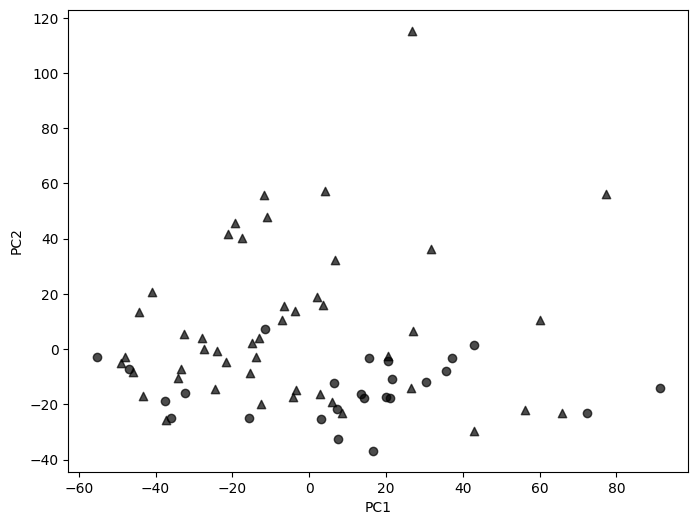

In [46]:
# Variables
x_col = 'PC1'  # Nom de la première colonne d'entiers
y_col = 'PC2'  # Nom de la deuxième colonne d'entiers
response = 'Y'  # Nom de la colonne variable de réponse

# Création du scatter plot
plt.figure(figsize=(8, 6))

X_pca_aml = X_pca[X_pca["Y"] == "AML"]
X_pca_all = X_pca[X_pca["Y"] == "ALL"]

scatter = plt.scatter(X_pca_aml[x_col], X_pca_aml[y_col], marker="o", c="black", alpha=0.7)
scatter = plt.scatter(X_pca_all[x_col], X_pca_all[y_col], marker="^", c="black", alpha=0.7)

# Ajouter des labels aux axes
plt.xlabel(x_col)
plt.ylabel(y_col)

# Afficher le graphique
plt.show()


*Résultats :*

En conclusion, on peut voir que la PCA n'est pas très concluante et on ne voit pas vraiment de clusters.

## 2. Groupement avec _k_-moyennes

Dans cette section, on vous demande de grouper les patients en utilisant la méthode des _k_-moyennes (avec initialisation _kmeans++_) et de trouver la valeur optimale du nombre de groupes entre 2 et 12, en utilisant l'indice de Davies-Bouldin et le score Silhouette.  Vous *ne* devez *pas* utiliser l'information du type de maladie.

Vu le nombre élevé d'attributs, vous réutiliserez les résultat de l'ACP faite ci-dessus, sans normalisation après l'ACP.

a. Pour les trois scores suivants, veuillez rappeler (en utilisant la documentation de sklearn) quel est leur intervalle de valeurs et quelles valeurs indiquent un meilleur groupement :
* l'indice de Davies-Bouldin
* le coefficient de Silhouette
* l'inertie.

*Réponse :*
- Daviez-Bouldin : Plus l'indice est proche de 0, plus les clusters sont similaires.
- Silhouette : Score allant de -1 à 1. Plus le score est proche de 1, plus les clusters sont denses et bien séparés.
- Inertie : Plus l'inertie est faible, plus les clusters sont denses.

b. Pour un nombre de groupes _k_ allant de 2 à 12 compris, veuillez effectuer le groupement avec _k_-moyennes, puis représenter sur trois graphiques la variation des trois scores intrinsèques en fonction de _k_.  Utiliser `n_init=10`.

In [47]:
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score

X = X_pca.iloc[:, :-1]

wss = []
davies_bouldin_scores = []
silouhette_scores = []

for i in range(2, 13):
    client_kmeans = KMeans(n_clusters=i, init='k-means++', n_init=10)
    client_kmeans.fit(X)
    wss.append(client_kmeans.inertia_)
    davies_bouldin_scores.append(davies_bouldin_score(X, client_kmeans.labels_))
    silouhette_scores.append(silhouette_score(X, client_kmeans.labels_))


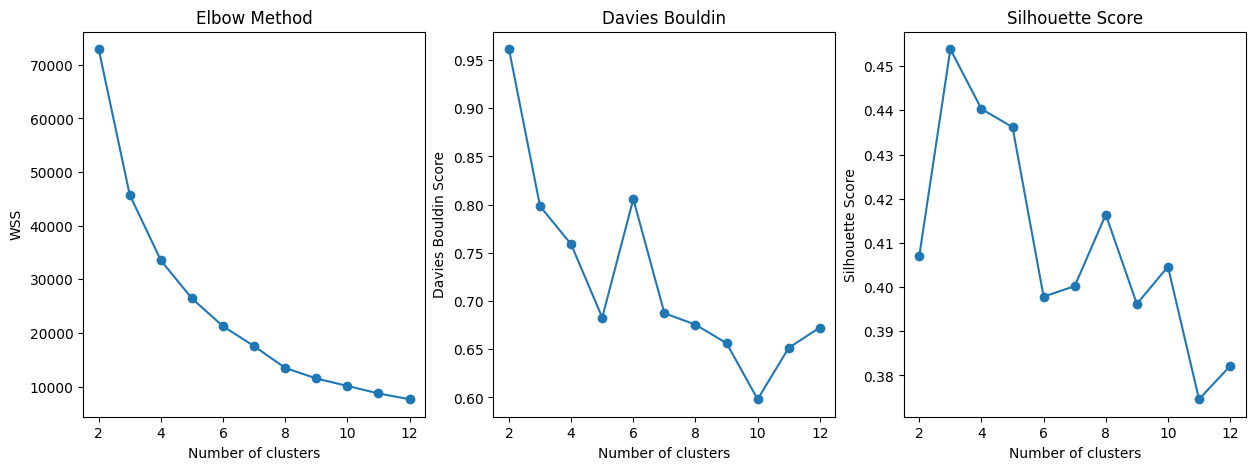

In [48]:
#Subplots
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# WSS
ax[0].plot(range(2, 13), wss, marker='o')
ax[0].set_title('Elbow Method')
ax[0].set_xlabel('Number of clusters')
ax[0].set_ylabel('WSS')

# Davies Bouldin
ax[1].plot(range(2, 13), davies_bouldin_scores, marker='o')
ax[1].set_title('Davies Bouldin')
ax[1].set_xlabel('Number of clusters')
ax[1].set_ylabel('Davies Bouldin Score')

# Silhouette
ax[2].plot(range(2, 13), silouhette_scores, marker='o')
ax[2].set_title('Silhouette Score')
ax[2].set_xlabel('Number of clusters')
ax[2].set_ylabel('Silhouette Score')

plt.show()

c. Selon les courbes affichées, quelle valeur de _k_ proposez-vous de retenir ?  Veuillez donner une raison.

Si vous exécutez plusieurs fois l'affichage des courbes, la valeur optimale de _k_ reste-t-elle la même ?  Que pouvez-vous en conclure ?

Note : si vous fixez l'attribut `random_seed` de KMeans, alors les courbes ne varient pas au fil des exécutions, sauf si vous changez `n_init`.

*Résultats :*
La valeur optimale de k serait 8 car elle optient des très bons score pour les trois indices et est très stable si on change le random_seed.

d. Avec la valeur de _k_ choisie au (c), veuillez calculer deux scores extrinsèques : l'indice de Rand ajusté et le score F1.  Veuillez commenter brièvement ces scores.

_Indication pour calculer le F1-score, qui n'est pas implémenté dans sklearn pour le groupement._  Pour chaque patient, assignez-lui le type qui est majoritaire dans son groupe (ALL ou AML) en utilisant les bonnes réponses.  Puis comparez les types ainsi assignés avec les types corrects en utilisant directement le score F1 de sklearn.  Notez que pour simplifier, cette méthode est un peu différente de celle du cours.

In [49]:
from sklearn.metrics import adjusted_rand_score
from collections import Counter

# Effectuer le groupement k-moyennes avec la meilleure valeur de k retenue au (b).
k = 8
optimal_kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10)
optimal_kmeans.fit(X)

# prediction
pred = optimal_kmeans.predict(X)

In [50]:
# Indice de Rand
print("Rand score : ", adjusted_rand_score(X_pca['Y'], pred))

# F1-score
df = pd.DataFrame({'Cluster': optimal_kmeans.labels_, 'Classe': X_pca['Y']})

class_by_cluster = df.groupby('Cluster')['Classe'].agg(lambda x: Counter(x).most_common(1)[0][0])

new_preds = np.full(len(pred), "N/A", dtype='<U10')
for cluster in class_by_cluster.index:
    new_preds[optimal_kmeans.labels_ == cluster] = class_by_cluster[cluster]

print("F1-score :", f1_score(X_pca['Y'].values, new_preds, average='micro'))

Rand score :  0.06495690195368527
F1-score : 0.7638888888888888


In [51]:
# Le rand score n'est pas très satisfaisant, il devrait être proche de 1.
# Le F1-score n'est pas si mal, la technique utilisé pour la prédiction semble prometteuse (prédire la classe majoritaire du cluster)

e. Veuillez représenter les points avec PCA en 2D, en gardant les marqueurs précédents pour les deux types (cercle et triangle), et en utilisant des couleurs pour coder les groupes trouvés. Suggestion : réutiliser le code du Labo 1.  Veuillez commenter le résultat.

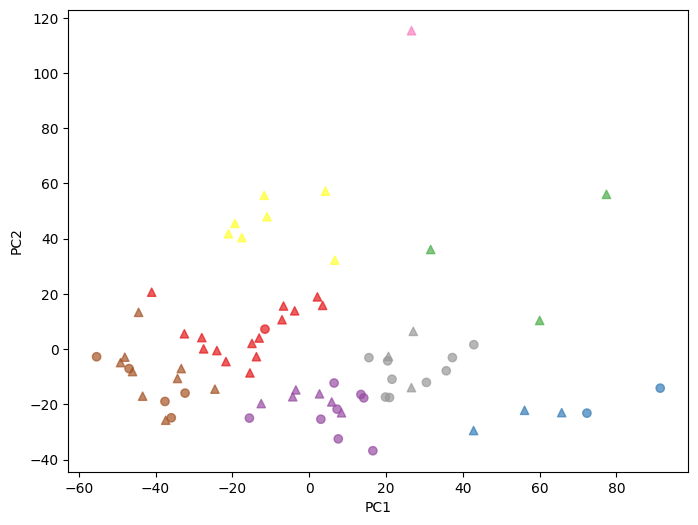

In [52]:
# Création du scatter plot
plt.figure(figsize=(8, 6))

X_pca_aml = X_pca[X_pca["Y"] == "AML"]
X_pca_all = X_pca[X_pca["Y"] == "ALL"]

scatter = plt.scatter(X_pca_aml[x_col], X_pca_aml[y_col], marker="o", c=optimal_kmeans.labels_[X_pca_aml.index], cmap='Set1', alpha=0.7)
scatter = plt.scatter(X_pca_all[x_col], X_pca_all[y_col], marker="^", c=optimal_kmeans.labels_[X_pca_all.index], cmap='Set1', alpha=0.7)

# Ajouter des labels aux axes
plt.xlabel(x_col)
plt.ylabel(y_col)

# Afficher le graphique
plt.show()


In [53]:
# On peut voir que, même si ce n'était pas visible au début de ce TP, le groupement en cluster fait sens quand on applique la prédiction avec la classe majoritaire du cluster.

## 3. Groupement avec DBSCAN

Dans cette section, vous répondrez aux mêmes questions que dans la section précédente, mais pour la méthode DBSCAN, en utilisant les mêmes mesures intrinsèques que ci-dessus (sauf l'inertie).

a. Veuillez représenter sur des _heatmaps_ la variation des deux scores intrinsèques et le nombre de groupes en fonction des paramètres _eps_ et _min_samples_ :
* chercher _eps_ entre 0.5 et 14 par sauts de 0.5
* chercher _min_samples_ entre 1 et 12

In [54]:
# Obtenir les deux scores et le nombre de groupes en variant les deux paramètres, les mettre dans des tableaux 2D

eps_values = np.arange(0.5, 14.5, 0.5)
min_samples_values = range(1, 13)

dbs_scores = np.zeros((len(eps_values), len(min_samples_values)))
sis_scores = np.zeros((len(eps_values), len(min_samples_values)))
n_groups = np.zeros((len(eps_values), len(min_samples_values)))

for i, eps in enumerate(eps_values):
    for j, min_samples in enumerate(min_samples_values):
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan.fit(X)
        n_groups[i, j] = len(set(dbscan.labels_))
        if len(set(dbscan.labels_)) > 1 and len(set(dbscan.labels_)) < len(X):
            dbs_scores[i, j] = davies_bouldin_score(X, dbscan.labels_)
            sis_scores[i, j] = silhouette_score(X, dbscan.labels_)
        else:
            dbs_scores[i, j] = np.nan
            sis_scores[i, j] = np.nan
            


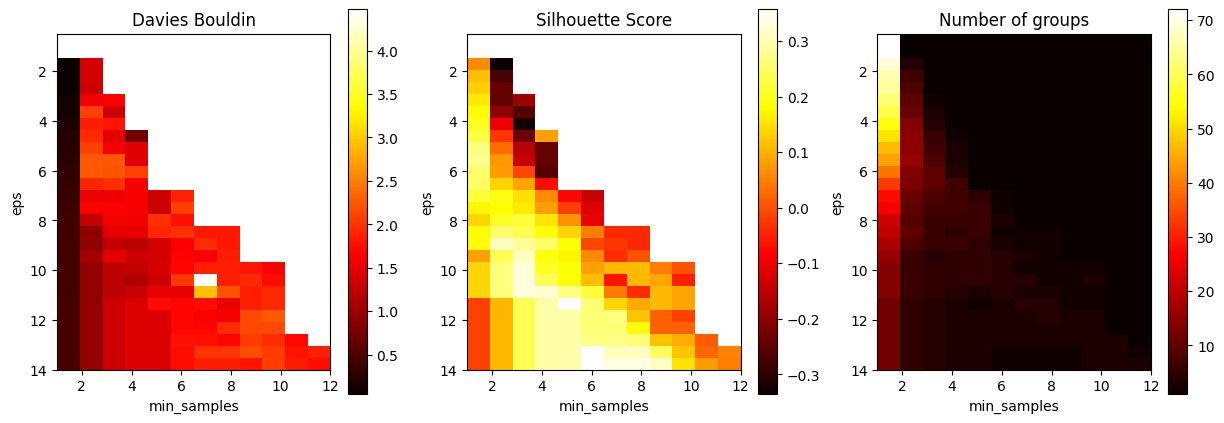

In [55]:
# Afficher les trois heatmaps : Davies_Bouldin, Silhouette, et Nombre_de_groupes
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# Davies Bouldin
im = ax[0].imshow(dbs_scores, cmap='hot', extent=[min_samples_values[0], min_samples_values[-1], eps_values[-1], eps_values[0]])
ax[0].set_title('Davies Bouldin')
ax[0].set_xlabel('min_samples')
ax[0].set_ylabel('eps')
fig.colorbar(im, ax=ax[0])

# Silhouette
im = ax[1].imshow(sis_scores, cmap='hot', extent=[min_samples_values[0], min_samples_values[-1], eps_values[-1], eps_values[0]])
ax[1].set_title('Silhouette Score')
ax[1].set_xlabel('min_samples')
ax[1].set_ylabel('eps')
fig.colorbar(im, ax=ax[1])

# Nombre de groupes
im = ax[2].imshow(n_groups, cmap='hot', extent=[min_samples_values[0], min_samples_values[-1], eps_values[-1], eps_values[0]])
ax[2].set_title('Number of groups')
ax[2].set_xlabel('min_samples')
ax[2].set_ylabel('eps')
fig.colorbar(im, ax=ax[2])

plt.show()


In [56]:
# Valeur "optimal" de eps et min_samples observée sur les graphiques
eps = 11
min_samples = 3

optimal_dbscan = DBSCAN(eps=eps, min_samples=min_samples)
optimal_dbscan.fit(X)

optimal_davies_bouldin = davies_bouldin_score(X, optimal_dbscan.labels_)
optimal_silhouette = silhouette_score(X, optimal_dbscan.labels_)
optimal_n_groups = len(set(optimal_dbscan.labels_))

print(f"Optimal value = eps: {eps}", f", min_samples: {min_samples}")
print(f"Optimal Davies Bouldin: {optimal_davies_bouldin}")
print(f"Optimal Silhouette: {optimal_silhouette}")
print(f"Optimal Number of groups: {optimal_n_groups}")

Optimal value = eps: 11 , min_samples: 3
Optimal Davies Bouldin: 1.2234945541212696
Optimal Silhouette: 0.3308442658517515
Optimal Number of groups: 5


b. Selon les scores trouvés, quelles valeurs de _eps_ et _min_samples_ proposez-vous de retenir ?  Pourquoi ?

Attention : les trois heatmaps ne sont pas toujours en accord, donc vous avez une certaine liberté pour choisir les deux paramètres (il n'y a pas d'optimum évident).

In [57]:
# Nous avons choisi les valeurs de eps et min_samples qui maximisent le score de silhouette et minimisent le score de Davies Bouldin.
# Ici cela nous fait les valeur eps = 11 et min_samples = 3.

c. Avec les valeurs choisies au (b), veuillez calculer les deux scores extrinsèques comme dans la partie (2).

In [58]:
# Effectuer le groupement DBSCAN avec les meilleurs paramètres,
# puis calculer l'indice de Rand ajusté et le score F1.

# Indice de Rand
print("Rand score : ", adjusted_rand_score(X_pca['Y'], optimal_dbscan.labels_))

# F1-score
df = pd.DataFrame({'Cluster': optimal_dbscan.labels_, 'Classe': X_pca['Y']})

class_by_cluster = df.groupby('Cluster')['Classe'].agg(lambda x: Counter(x).most_common(1)[0][0])

new_preds = np.full(len(optimal_dbscan.labels_), "N/A", dtype='<U10')
for cluster in class_by_cluster.index:
    new_preds[optimal_dbscan.labels_ == cluster] = class_by_cluster[cluster]

print("F1-score :", f1_score(X_pca['Y'].values, new_preds, average='micro'))

Rand score :  0.09529761622671912
F1-score : 0.7777777777777778


In [59]:
# Le rand score est très mauvais, il est proche de 0, mais est meilleur que le rand score obtenu avec le KMeans.
# Le F1-score n'est pas si mal et est légerement supérieur à celui obtenu avec le KMeans.

d. Veuillez représenter les points en 2D avec la même représentation que ci-dessus : utilisez des marques différentes pour les deux types, et des couleurs pour coder les groupes trouvés.  Veuillez commenter le résultat.

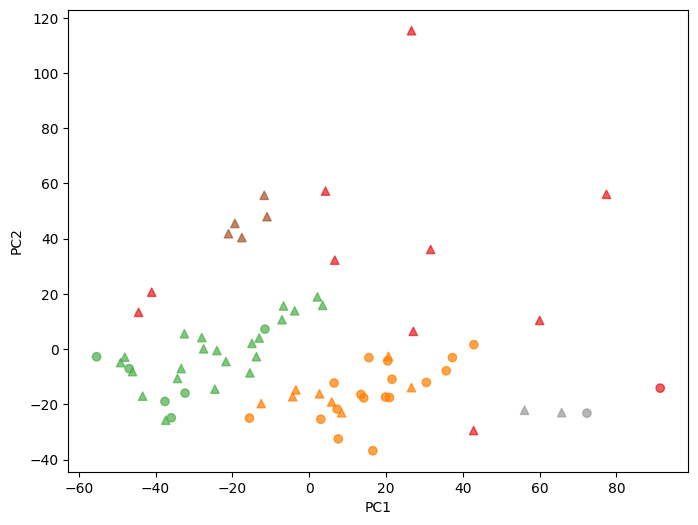

In [60]:
# Création du scatter plot
plt.figure(figsize=(8, 6))

X_pca_aml = X_pca[X_pca["Y"] == "AML"]
X_pca_all = X_pca[X_pca["Y"] == "ALL"]

scatter = plt.scatter(X_pca_aml[x_col], X_pca_aml[y_col], marker="o", c=optimal_dbscan.labels_[X_pca_aml.index], cmap='Set1', alpha=0.7)
scatter = plt.scatter(X_pca_all[x_col], X_pca_all[y_col], marker="^", c=optimal_dbscan.labels_[X_pca_all.index], cmap='Set1', alpha=0.7)

# Ajouter des labels aux axes
plt.xlabel(x_col)
plt.ylabel(y_col)

# Afficher le graphique
plt.show()


In [61]:
# Le groupement en cluster semble être plus pertinent avec DBSCAN qu'avec KMeans.
# On peut voir que les clusters sont plus homogènes et que les points sont plus proches les uns des autres.
# On voit aussi que nous avons créer un groupe pour toutes les valeurs atypiques se qui n'est peut-être pas souhaitable.

## 4. Conclusion

Comment se comparent les deux méthodes optimisées, en termes de scores extrinsèques ?  Veuillez discuter les paramètres trouvés et les scores obtenus.  En particulier, y a-t-il des sous-types des leucémies ALL et AML qui sont visibles sur les groupements que vous obtenus ?  Combien pour chacun ?

In [62]:
# Le groupement en cluster semble être plus pertinent avec DBSCAN qu'avec KMeans.
# Les scores de silhouette et de Davies Bouldin sont meilleurs avec KMeans, mais les scores de Rand et de F1 sont meilleurs avec DBSCAN.
# Cela est peut être dû au fait que DBSCAN a créé un groupe pour les valeurs atypiques, ce qui n'est peut-être pas souhaitable.

# Les deux méthodes ont donnée un nombre de groupes de respectivement 8 (KMeans) et 5 (DBSCAN), ce qui nous laisse penser qu'il existerai plusieurs sous-types de leucémie.

***
**Fin du Labo 2.**  Veuillez nettoyer ce notebook en gardant seulement les réponses et résultats désirés, l'enregistrer en remplaçant 'student' par votre nom, et le soumettre sur Cyberlearn.